## Computing influence function of non-protected attributes

In this tutorial, we compute influence of non-protected attributes in determining bias in the decision process. To compute the influence of an attribute, we modify it with random values and record differences in <em>measures of interests</em> such as disparate impact, statisitcal parity. Intuitively, the influence denotes how much a measure will change due to the attribute.

### Outline
- Train a classifier on a dataset
- Compute base values (without perturbation)
- For each attribute, replace values with random values and report differences in disparate impact, statistical parity and positive predictive value (probability of a classifier predicting the positive class)
- Plot results

In [1]:
# standard library
import sklearn.metrics
from sklearn.model_selection import train_test_split
from pyrulelearn.imli import imli
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown, display
import sys
from tqdm import tqdm
import pandas as pd
sys.path.append("..")

# From this framework
from data.objects.ricci import Ricci
from data.objects.adult import Adult
from data.objects.compas import Compas
from data.objects.titanic import Titanic
from data.objects.german import German
import justicia.utils
from justicia.metrics import Metric


### Prepare a dataset

In [2]:
verbose = False
dataset = Compas(verbose=verbose, config=2) # config defines configuration for sensitive groups
df = dataset.get_df()
# get X,y
X = df.drop(['target'], axis=1)
y = df['target']
display(Markdown("#### Sensitive attributes"))
print(dataset.known_sensitive_attributes)
display(Markdown("#### Feature matrix"))
print("Before one hot encoding")
attributes = X.columns
X.head()


#### Sensitive attributes

['sex']


#### Feature matrix

Before one hot encoding


,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree
0,Male,0.653846,Other,0.0,0.000000,0.000000,0.000000,F
1,Male,0.205128,African-American,0.0,0.000000,0.000000,0.000000,F
2,Male,0.076923,African-American,0.0,0.000000,0.058824,0.105263,F
3,Male,0.064103,African-American,0.0,0.076923,0.000000,0.026316,F
4,Male,0.320513,Other,0.0,0.000000,0.000000,0.052632,F


In [3]:
# one-hot encoding for categorical features (this takes care of Label encoding automatically)
X = justicia.utils.get_one_hot_encoded_df(X,dataset.categorical_attributes, verbose=True)
print("After->")    
X.head(n=10)



Apply one-hot encoding on categircal attributes
Applying following mapping on attribute sex => Male : 0 | Female : 1
race  has more than two unique categories ['African-American', 'Asian', 'Caucasian', 'Hispanic', 'Native American', 'Other']
Applying following mapping on attribute c_charge_degree => F : 0 | M : 1
two_year_recid  is not considered in classification


After->


,sex,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other
0,0,0.653846,0.0,0.000000,0.000000,0.000000,0,0,0,0,0,0,1
1,0,0.205128,0.0,0.000000,0.000000,0.000000,0,1,0,0,0,0,0
2,0,0.076923,0.0,0.000000,0.058824,0.105263,0,1,0,0,0,0,0
3,0,0.064103,0.0,0.076923,0.000000,0.026316,0,1,0,0,0,0,0
4,0,0.320513,0.0,0.000000,0.000000,0.052632,0,0,0,0,0,0,1
5,0,0.333333,0.0,0.000000,0.000000,0.000000,1,0,0,0,0,0,1
6,0,0.294872,0.0,0.000000,0.000000,0.368421,0,0,0,1,0,0,0
7,0,0.320513,0.0,0.000000,0.000000,0.078947,0,0,0,0,0,0,1
8,1,0.269231,0.0,0.000000,0.000000,0.000000,1,0,0,1,0,0,0
9,0,0.038462,0.0,0.000000,0.000000,0.026316,0,0,0,1,0,0,0


### Train a classifier

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle = True, random_state=2) # 70% training and 30% test

# clf = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=0)
clf = tree.DecisionTreeClassifier(max_depth=5)
# clf = SVC(kernel="linear")


clf.fit(X_train.values, y_train.values)
print("\nTrain Accuracy:", sklearn.metrics.accuracy_score(clf.predict(X_train.values),y_train.values))
print("Test Accuracy:", sklearn.metrics.accuracy_score(clf.predict(X_test.values),y_test.values))        


Train Accuracy: 0.6829944547134935
Test Accuracy: 0.6800554016620498


### Define function to randomly replace a column in data
- For continuous-valued attributes, a random value is chosen within the minimum and maximum of attribute-values
- For categorical-valued attributes, a random value is chosen from all possible categories

In [5]:
def random_replace(df, column, is_categorical):
    """
        Input is a dataframe and a column in the dataframe
    """
    if(column in df.columns):
        # Either Binary or continuous columns
        uniques = df[column].unique()
        if(is_categorical):
            # considered as categorical, hence we select one of the categories randomly
            random_values = np.random.choice(uniques, df.shape[0])
            # In case, one or more categories are missing, we push them uniformly at random
            uniques_random = np.unique(random_values)
            assert len(uniques) == len(uniques_random), uniques
        else:
            # random values between min and max
            random_values = np.random.uniform(low = df[column].min(), high = df[column].max(), size=(df.shape[0],))
        
        # replace column
        df[column] = random_values
        
    else:
        # find all matching columns within one-hot encode
        matching_columns = []
        for df_column in df.columns:
            if df_column.startswith(column) and "_" in df_column:
                matching_columns.append(df_column)
        random_values = np.random.choice(range(len(matching_columns)), df.shape[0])
        random_values = pd.get_dummies(random_values)
        random_values.columns = matching_columns
        for matching_column in matching_columns:
            df[matching_column] = random_values[matching_column].values


    return df

In [6]:
result = pd.DataFrame()
encoding = "Enum-dependency"

# base result
base_metric = Metric(model=clf, data=X_test, sensitive_attributes=dataset.known_sensitive_attributes, verbose=False, encoding="Enum-dependency")
base_metric.compute()
assert base_metric.disparate_impact_ratio is not None

max_iterations = 5
print("Total iterations", max_iterations)
for iteration in range(max_iterations):
    for attribute in tqdm(attributes, leave=True):
        # We do not compute influence w.r.t. sensitive attributes
        attribute_is_sensitive_attribute = False
        for var in dataset.known_sensitive_attributes:
            if((attribute.startswith(var) and "_" in attribute) or attribute == var):
                attribute_is_sensitive_attribute = True

        if(attribute_is_sensitive_attribute):
            continue
        
        # influence computation
        working_df = X.copy()
        working_df = random_replace(working_df, attribute, is_categorical = attribute in dataset.categorical_attributes)
        metric = Metric(clf, working_df, sensitive_attributes=dataset.known_sensitive_attributes, verbose=False, encoding=encoding).compute()


        # report results
        entry = {}
        entry['encoding'] = encoding
        entry['attribute'] = attribute
        entry['sensitive attributes'] = dataset.known_sensitive_attributes
        entry['sensitive groups statistics'] = metric.sensitive_group_statistics
        entry['base sensitive groups statistics'] = base_metric.sensitive_group_statistics
        entry['DI'] = None
        entry['SP'] = None
        entry['base DI'] = base_metric.disparate_impact_ratio
        entry['base SP'] = base_metric.statistical_parity_difference
        try:
            entry['DI'] = metric.disparate_impact_ratio - base_metric.disparate_impact_ratio
            entry['SP'] = metric.statistical_parity_difference - base_metric.statistical_parity_difference
        except:
            pass
        result = result.append(entry, ignore_index=True)

        
                                        

100%|██████████| 8/8 [00:12<00:00,  1.53s/it]


## Visualize results
- Change in disparate impact
- Change in statistical parity
- Change in positive predictive value of the classifier for all combinations of sensitive groups

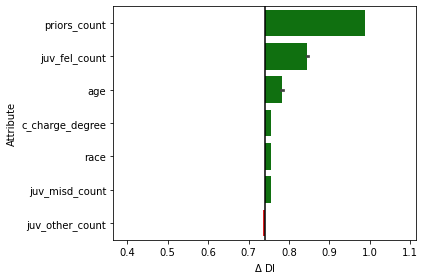

<Figure size 432x288 with 0 Axes>

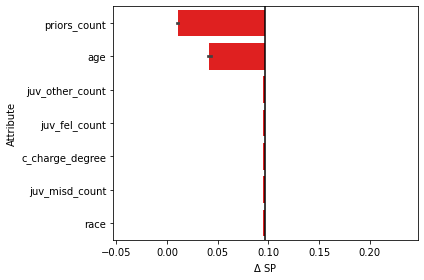

<Figure size 432x288 with 0 Axes>

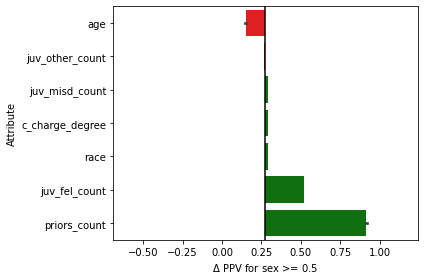

<Figure size 432x288 with 0 Axes>

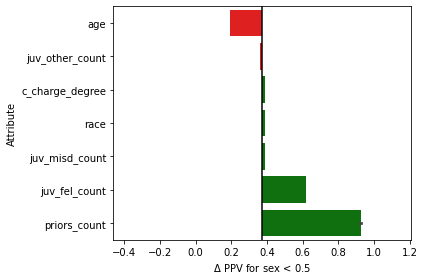

<Figure size 432x288 with 0 Axes>

In [7]:

item = result.copy()    
dic = {
    "DI" : r"$\Delta$" + " DI",
    "SP" : r"$\Delta$" + " SP",
}
item['len sensitive groups statistics'] = item.apply(lambda x: len(x['sensitive groups statistics']), axis=1)

assert len(item['len sensitive groups statistics'].unique()) == 1

for idx, group_info in enumerate(item['base sensitive groups statistics'].iloc[0]):
    item["base PPV " + str(group_info[0])] = item.apply(lambda x: x['base sensitive groups statistics'][idx][1], axis=1)
    item["PPV " + str(group_info[0])] = item.apply(lambda x: x['sensitive groups statistics'][idx][1] - x["base PPV " + str(group_info[0])], axis=1)
    dic["PPV " + str(group_info[0])] = r"$\Delta$" + " PPV for " + str((", ").join((" ").join([attr, val[0], str(val[1])]) for attr, val in group_info[0]))


fontsize = 22
labelsize = 18
for dic_key in dic:

    assert len(item['base ' + dic_key].unique()) == 1, item['base ' + dic_key].unique()
    base_val = item['base ' + dic_key].iloc[0]
    max_val = max(max(abs(item[dic_key].max()), abs(item[dic_key].min())) , 0.1)
    # custom color for each feature
    custom_palette = {}
    custom_palette_base = {}
    for q in set(item['attribute']):
        avr = (np.average(item[item['attribute'] == q][dic_key]))
        if avr > 0:
            custom_palette[q] = 'green'
            custom_palette_base[q] = 'white'
        else:
            custom_palette[q] = 'red'
            custom_palette_base[q] = 'white'
    
    # sort results
    if(dic_key == "DI"):
        item.sort_values(dic_key, ascending=False, inplace=True)
    else:
        item.sort_values(dic_key, ascending=True, inplace=True)
    
    # review values
    item['temp base ' + dic_key] = item.apply(lambda x: x['base ' + dic_key] if x[dic_key] > 0 else x[dic_key] + x['base ' + dic_key], axis=1)
    item[dic_key] = item.apply(lambda x: x[dic_key] + x['base ' + dic_key] if x[dic_key] > 0 else x['base ' + dic_key], axis=1)
    item['base ' + dic_key] = item.apply(lambda x: x['temp base ' + dic_key], axis=1)

    fig, ax = plt.subplots()
    sns.barplot(y='attribute', x=dic_key, palette=custom_palette, data=item)
    g = sns.barplot(y='attribute', x='base ' + dic_key, palette=custom_palette_base, data=item)
    g.axvline(base_val, color='black')
    plt.xlim(base_val - 1.5 * max_val, base_val + 1.5 * max_val)
    plt.ylabel('Attribute')
    plt.xlabel(dic[dic_key])
    plt.legend("", frameon=False)
    plt.tight_layout()
    
    plt.show()
    plt.clf()
    
